# Classical ML based Feature Selection - Sequences Merged

### 1. Reading and Processing the stable radiomic features

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

import numpy as np

In [2]:
OUT_PATH=r"./results"
FEAT_PATH = r"./features_StudySettings3D.csv"
INT_ICC_PATH = r"./stability_study_results/INT_Clinical/inout_plane_systematic_features_StudySettings3D.csv"
EXT_ICC_PATH = r"./stability_study_results/QIN_NonClinical_Dependent/inout_plane_systematic_features_StudySettings3D.csv"

SEQUENCE_BESTFILTER_PREFIX = {
    
                "t2w":["original_shape","logarithm_firstorder","logarithm_glcm","logarithm_glszm","logarithm_glrlm","logarithm_gldm","logarithm_ngtdm"],
               
                "adc":["original_shape","log-sigma-5-0-mm-3D_firstorder","square_glcm","exponential_glszm","exponential_glrlm","exponential_gldm","exponential_ngtdm"],
                
                "dce_win":["original_shape","logarithm_firstorder","logarithm_glcm","wavelet-HLL_glszm","logarithm_glrlm","square_gldm","logarithm_ngtdm"],
                
                "dce_wout":["original_shape","logarithm_firstorder","logarithm_glcm","logarithm_glszm","logarithm_glrlm","logarithm_gldm","logarithm_ngtdm"]
                
               }

ICC_THRESHOLD = 0.90

In [3]:
feat_df = pd.read_csv(FEAT_PATH)
int_icc_df = pd.read_csv(INT_ICC_PATH, index_col=0)
ext_icc_df = pd.read_csv(EXT_ICC_PATH, index_col=0)

In [4]:
selected_feats = {}

for i, row_int  in int_icc_df.iterrows():
    
    feature, _, c_down_int, _, sequence = row_int
       
    row_ext = ext_icc_df[ext_icc_df.feature==feature][ext_icc_df.sequence==sequence.split("_")[0]]#this is because for internal set there is dce_win and dce_wout, but for external there is only dce
    
    _, _, c_down_ext, _, _ = row_ext.values[0].tolist()

    if c_down_int>=ICC_THRESHOLD and c_down_ext>=ICC_THRESHOLD:
    
        prefices = SEQUENCE_BESTFILTER_PREFIX[sequence]

        for prefix in prefices:

            if prefix in feature:
                selected_feats.setdefault(sequence,[]).append(feature)
                

c:\sithin\myenv\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


### 2. Merged Features of all the sequences

In [5]:
features = []

merged_df = {}

for sequence,feats in selected_feats.items():### 9. Compute Delta based on mean
    
    for feat in feats:
        features.append(sequence+"_"+feat)
        merged_df[sequence+"_"+feat] = feat_df[feat_df.sequence==sequence].sort_values(by=['id'])[feat].values

merged_df["label"] = feat_df[feat_df.sequence==sequence].sort_values(by=['id'])["label"].values
merged_df["id"] = feat_df[feat_df.sequence==sequence].sort_values(by=['id'])["id"].values
    
merged_df = pd.DataFrame.from_dict(merged_df)


In [6]:
#merged_df.to_csv("merged_df.csv",index=False)

### 3. Sort Features In an Orderly Way (Pearson correlation is dependent on that, Simple to Complex features)

In [7]:
def sort_feats(features):

    sorted_features = []

    for sequence in ["t2w","adc","dce_win","dce_wout"]:

        for feat_type in ["shape","firstorder","glcm","glszm","glrlm","gldm","ngtdm"]:

            feats = sorted([feat for feat in features if sequence in feat and feat_type in feat and feat not in sorted_features])

            sorted_features += feats
            
    return sorted_features
        

In [8]:
features = sort_feats(features)

In [9]:
len(features)

321

#### Class Distribution

In [10]:
merged_df["label"].value_counts()

0    69
1    31
Name: label, dtype: int64

<AxesSubplot:>

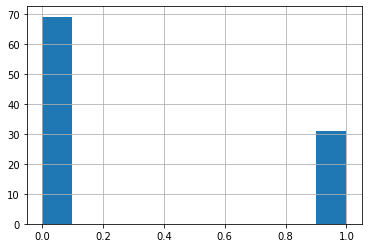

In [11]:
merged_df["label"].hist()

### 4. Removing features with zero variance

In [12]:
var_threshold = 0.0

In [13]:
feats,var_tags = zip(*((merged_df[features].var()<=var_threshold).to_dict()).items())
low_variance_features = list(np.array(feats)[np.array(var_tags)])

features = list(set(features) - set(low_variance_features))
print(f"Removed {len(low_variance_features)}; {len(features)} remaining")

Removed 0; 321 remaining


In [14]:
features = sort_feats(features)

### 5. Shape and Volume Correlated Feature Filtering

In [15]:
R_THRESHOLD = 0.85

In [16]:
#Removing Features Correlated with Shape which includes volume features as well

to_drop = []
corr = merged_df[features].corr(method="pearson").abs()
corr_dict = corr.to_dict()

for feat in features:

    if "original_shape" in feat:

        _to_drop = [key for key,val in corr_dict[feat].items() if val>=R_THRESHOLD and key not in to_drop]
        to_drop += _to_drop

    
features = list(set(features)-set(to_drop))
print(f"{len(to_drop)} highly shape correlated features deleted, {len(features)} features remaining")


58 highly shape correlated features deleted, 263 features remaining


In [17]:
features = sort_feats(features)

### 7. Feautre filtering using pearson correlation coefficient on the merged dataframe

In [18]:
R_THRESHOLD = 0.85

In [19]:
corr = merged_df[features].corr(method="pearson").abs()#order matters actually here
up_tri = corr.where(np.triu(np.ones(corr.shape),k=1).astype(bool))
to_drop = [column for column in up_tri.columns if any(up_tri[column] >= R_THRESHOLD)]
filtered_features = list(set(features)-set(to_drop))


print(f"{len(to_drop)} highly correlated features deleted, {len(filtered_features)} features remaining")


197 highly correlated features deleted, 66 features remaining


In [20]:
filtered_features = sort_feats(filtered_features)

#### Visualizing clusters using PCA and t-SNE

In [21]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

In [22]:
SEED = 0

In [23]:
def visualize(features, labels, n_components, sequence):
 
    features = features.copy()
    
    scaler = StandardScaler()#it is necessary to ensure that the scale is similar
    features = scaler.fit_transform(features)

    embedding = {}
    
    embedding["pca"] = PCA(n_components = n_components, random_state=SEED).fit_transform(features)
    embedding["tsne"] = TSNE(n_components=n_components,random_state=SEED).fit_transform(features)
        
    
    # initialising the plot
    
    fig = plt.figure()
    
    for i,key in enumerate(embedding.keys()):
    
        ax = fig.add_subplot(1,2,i+1)

        # plotting data
        ax.scatter(*zip(*embedding[key][np.where(labels==1)]),marker='o',color='r',s=10,alpha=0.7,label='Class-1')
        ax.scatter(*zip(*embedding[key][np.where(labels==0)]),marker='o',color='g',s=10,alpha=0.3,label='Class-0')
        ax.set_title(f"{sequence}-{key}")
        ax.legend()

    

    plt.show
    

c:\sithin\myenv\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
c:\sithin\myenv\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


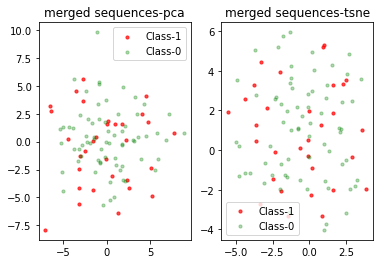

In [24]:
num_components = 2
  
feats = merged_df[filtered_features].to_numpy()
labels = merged_df["label"].to_numpy()
    
visualize(feats, labels, num_components,"merged sequences")

### 8. Feature Selection using classical ML Models using Backward Elimination Technique

Linear Model: LogisticRegression

Non Linear Model: RandomForestClassifier & SVC

In [25]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)#because of xgboost warnings

In [26]:
from sklearn.feature_selection import SequentialFeatureSelector as SFS
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import time



# from boruta import BorutaPy
# from sklearn.feature_selection import RFECV, RFE
# import xgboost as xgb

In [27]:
out_path = os.path.join(OUT_PATH,"all_sequences")
if not os.path.exists(out_path):
    os.makedirs(out_path)
    
if os.path.exists(os.path.join(out_path,"exe_stat.npy")):
    exe_stat = np.load(os.path.join(out_path,"exe_stat.npy"),allow_pickle=True).item()
else:
    exe_stat = {}

In [28]:
rskf = RepeatedStratifiedKFold(n_splits=3, n_repeats=100,random_state=0)

estimators = [
    LogisticRegression(penalty='none'),
    SVC(),
    RandomForestClassifier() 
    
]

# xgb.XGBClassifier(use_label_encoder=False,objective='binary:logistic',eval_metric="logloss")

#### Backward SequentialFeatureSelector Function

In [29]:
def run_bsfs(estimator, filtered_features):
    
    n = len(filtered_features)
    rank_dict = {}
    
    pbar = tqdm(range(n-1),desc=f"Running Backwards SFS with {estimator.__class__.__name__}", position=0)
    
    while n>1:
    
        X = merged_df[filtered_features].to_numpy()
        y = merged_df["label"].to_numpy().ravel()

        sfs_pipeline = make_pipeline(StandardScaler(), SFS(estimator, n_features_to_select=n-1, direction='backward', scoring="roc_auc", cv=rskf))
        sfs_pipeline.fit(X,y)
          

        eliminated_feature = np.array(filtered_features)[~sfs_pipeline['sequentialfeatureselector'].support_][0]
        rank_dict[eliminated_feature] = n

        filtered_features = np.array(filtered_features)[sfs_pipeline['sequentialfeatureselector'].support_]

        n -= 1
        
        pbar.update()
    
    rank_dict[filtered_features[0]] = n
        
        
    return rank_dict
    

### 9. Compute the ranks and Export the ranks generated by each estimator

In [30]:
for estimator in estimators:

    if not os.path.exists(os.path.join(out_path,f"BSFS-{estimator.__class__.__name__}.csv")):
        
        start_time = time.time()

        _rank_dict = run_bsfs(estimator, filtered_features)
        _rank_dict = dict(sorted(_rank_dict.items(), key=lambda item: item[1]))

        feats, ranks = zip(*_rank_dict.items())

        rank_dict = {"feature":list(feats),"rank":list(ranks)}
        rank_df = pd.DataFrame.from_dict(rank_dict)
        rank_df.to_csv(os.path.join(out_path,f"BSFS-{estimator.__class__.__name__}.csv"),index=False)
        
        exe_stat[estimator.__class__.__name__] = (time.time() - start_time)
        np.save(os.path.join(out_path,"exe_stat.npy"),exe_stat)
        
        print(f"BSFS-{estimator.__class__.__name__} => Execution Time :{exe_stat[estimator.__class__.__name__]}")
    else:
        
        print(f"BSFS-{estimator.__class__.__name__} => Execution Time :{exe_stat[estimator.__class__.__name__]}")

BSFS-LogisticRegression => Execution Time :4954.029000043869
BSFS-SVC => Execution Time :1781.944000005722
BSFS-RandomForestClassifier => Execution Time :92919.5964474678


In [45]:
exe_stat

{'LogisticRegression': 4954.029000043869,
 'SVC': 1781.944000005722,
 'RandomForestClassifier': 92919.5964474678,
 'autoencoder': 782.7470002174377}

### 10. Final Radiomics Signature  Validation

In [31]:
if os.path.exists(os.path.join(OUT_PATH,"signatures_merged.csv")):
    signatures = pd.read_csv(os.path.join(OUT_PATH,"signatures_merged.csv"))
else:
    signatures = pd.DataFrame.from_dict({})
    

In [32]:
NUM_FEATS = 4

In [33]:
for estimator in estimators:
    
    rank_df = pd.read_csv(os.path.join(out_path,f"BSFS-{estimator.__class__.__name__}.csv"))

    radiomics_signature = rank_df.feature[rank_df["rank"]<=NUM_FEATS].to_list()
    

    X = merged_df[radiomics_signature]
    y = merged_df["label"].to_numpy().ravel()

    estimator_pipeline = make_pipeline(StandardScaler(), estimator)
    results = cross_validate(estimator_pipeline, X, y, scoring=["roc_auc"],verbose=1,cv=rskf)

    roc_auc = results["test_roc_auc"]

    print(f"Estimator:{estimator.__class__.__name__}, feat_count:{len(radiomics_signature)}, roc_auc:{roc_auc.mean():0.2}+-{roc_auc.std():0.2}")
    print(f"Selected Features:{radiomics_signature}")
    
    signatures["BSFS_"+estimator.__class__.__name__] = radiomics_signature
    
    print("\n")

#signatures.to_csv(os.path.join(OUT_PATH,"signatures_merged.csv"),index=False)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    3.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Estimator:LogisticRegression, feat_count:4, roc_auc:0.74+-0.074
Selected Features:['t2w_logarithm_glszm_LargeAreaHighGrayLevelEmphasis', 'dce_win_logarithm_firstorder_Energy', 'dce_wout_logarithm_glszm_SizeZoneNonUniformity', 'adc_exponential_glszm_LargeAreaEmphasis']




[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Estimator:SVC, feat_count:4, roc_auc:0.79+-0.072
Selected Features:['adc_exponential_glszm_ZonePercentage', 'dce_win_logarithm_firstorder_90Percentile', 'adc_log-sigma-5-0-mm-3D_firstorder_Maximum', 'dce_wout_logarithm_glrlm_LongRunLowGrayLevelEmphasis']


Estimator:RandomForestClassifier, feat_count:4, roc_auc:0.84+-0.067
Selected Features:['adc_exponential_glszm_LargeAreaEmphasis', 'dce_win_logarithm_glrlm_LongRunLowGrayLevelEmphasis', 'adc_log-sigma-5-0-mm-3D_firstorder_Maximum', 't2w_logarithm_glszm_LargeAreaHighGrayLevelEmphasis']




[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   57.5s finished


# Permutation Test

In [38]:
from sklearn.model_selection import permutation_test_score

In [43]:
export_path = r"C:\Sithin\autoencoder\permutation_results\merged-sequence"
if not os.path.exists(export_path):
    os.makedirs(export_path)

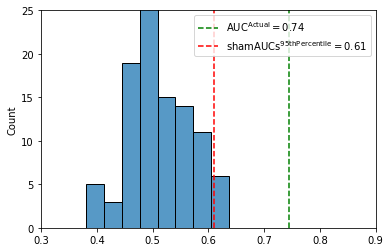

Estimator:LogisticRegression, Actual roc-auc: 0.743745718050066, Range of sham roc-aucs:((0.3804835309617918, 0.6374664031620554)), p-value:0.009900990099009901, Distance:0.13353267457180518


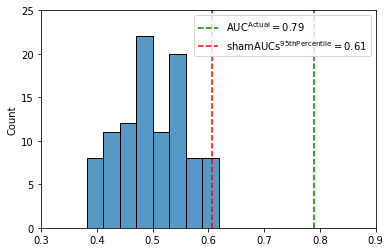

Estimator:SVC, Actual roc-auc: 0.7892305665349143, Range of sham roc-aucs:((0.38204084321475623, 0.6189512516469038)), p-value:0.009900990099009901, Distance:0.1831102766798418


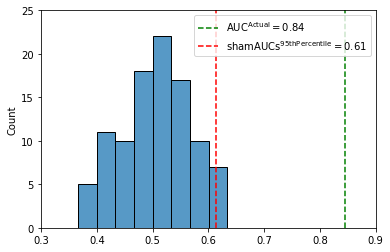

Estimator:RandomForestClassifier, Actual roc-auc: 0.8440191040843216, Range of sham roc-aucs:((0.36633069828722, 0.6337187088274044)), p-value:0.009900990099009901, Distance:0.2302741436100133


In [44]:
if not os.path.exists(os.path.join(out_path,"bsfs_permutation_test.npy")):
    results = {}
    for estimator in estimators:
    
        radiomics_signature = signatures["BSFS_"+estimator.__class__.__name__].to_list()

        X = merged_df[radiomics_signature]
        y = merged_df["label"].to_numpy().ravel()

        estimator_pipeline = make_pipeline(StandardScaler(), estimator)
        mean_rocauc, permuted_rocaucs, p_value = permutation_test_score(estimator_pipeline, X, y, scoring="roc_auc",verbose=1,cv=rskf)

        results[estimator.__class__.__name__] = {"p_value":p_value,"mean_auc":mean_rocauc,"permuted_aucs":permuted_rocaucs}
        
    np.save(os.path.join(out_path,"bsfs_permutation_test.npy"),results)
    
else:
    results = np.load(os.path.join(out_path,"bsfs_permutation_test.npy"),allow_pickle=True).item()
    

# for estimator in results:
    
#     p_value = results[estimator]["p_value"]
#     mean_rocauc = results[estimator]["mean_auc"]
#     permuted_rocaucs = results[estimator]["permuted_aucs"]
    
#     sns.histplot(permuted_rocaucs)
#     plt.axvline(mean_rocauc)
#     plt.show()

#     distance = mean_rocauc - np.percentile(permuted_rocaucs, 95)

#     print(f"Estimator:{estimator.__class__.__name__}, Actual roc-auc: {mean_rocauc}, Range of sham roc-aucs:({min(permuted_rocaucs),max(permuted_rocaucs)}), p-value:{p_value}, Distance:{distance}")


for estimator in results:
    
    p_value = results[estimator]["p_value"]
    mean_rocauc = results[estimator]["mean_auc"]
    permuted_rocaucs = results[estimator]["permuted_aucs"]
    
    params = {'mathtext.default':'regular'}
    plt.rcParams.update(params)
    
    fig = plt.figure()
    ax = fig.gca()
    
    sns.histplot(permuted_rocaucs, ax=ax)
    ax.set_xlim(0.3,0.9)
    ax.set_ylim(0,25)
    plt.axvline(mean_rocauc, label="$AUC^{Actual}$"+f"$={mean_rocauc:0.2f}$", color='g', ls='--')
    
    percentile95 = np.percentile(permuted_rocaucs, 95)
    
    plt.axvline(percentile95, label="$shamAUCs^{95th Percentile}$"+f"$={percentile95:0.2f}$", color='r', ls='--')
    plt.legend(loc="upper right")
    plt.savefig(os.path.join(export_path,f"control-{estimator}.png"),dpi=300)
    plt.show()

    distance = mean_rocauc - percentile95#np.percentile(permuted_rocaucs, 95)
    
    

    print(f"Estimator:{estimator}, Actual roc-auc: {mean_rocauc}, Range of sham roc-aucs:({min(permuted_rocaucs),max(permuted_rocaucs)}), p-value:{p_value}, Distance:{distance}")
    




# Forward SequentialFeatureSelector

In [ ]:
# def run_fsfs(estimator, filtered_features):
    
#     rank_dict = {}
    
#     _filtered_features = list(filtered_features)
    
#     n = len(filtered_features)
#     pbar = tqdm(range(n),desc="Running Forward SFS", position=0)
    
#     for i in range(n-1):
    
#         X = merged_df[filtered_features].to_numpy()
#         y = merged_df["label"].to_numpy().ravel()

#         sfs_pipeline = make_pipeline(StandardScaler(), SFS(estimator, n_features_to_select=1, direction='forward', scoring="roc_auc", cv=rskf))
#         sfs_pipeline.fit(X,y)

#         selected_feature = np.array(filtered_features)[sfs_pipeline['sequentialfeatureselector'].support_][0]
#         rank_dict[selected_feature] = i+1

#         filtered_features = np.array(filtered_features)[~sfs_pipeline['sequentialfeatureselector'].support_]

        
#         pbar.update()
    
    
    
#     final_feature = list(set(_filtered_features) - set(rank_dict.keys()))[0]
#     rank_dict[final_feature] = n
        
        
#     return rank_dict
    

In [ ]:
# for estimator in estimators:
    
#     if not os.path.exists(os.path.join(out_path,f"FSFS-{estimator.__class__.__name__}.csv")):

#         _rank_dict = run_fsfs(estimator, filtered_features)
#         _rank_dict = dict(sorted(_rank_dict.items(), key=lambda item: item[1]))

#         feats, ranks = zip(*_rank_dict.items())

#         rank_dict = {"feature":list(feats),"rank":list(ranks)}
#         rank_df = pd.DataFrame.from_dict(rank_dict)
#         rank_df.to_csv(os.path.join(out_path,f"FSFS-{estimator.__class__.__name__}.csv"),index=False)
#     else:
#         rank_df = pd.read_csv(os.path.join(out_path,f"FSFS-{estimator.__class__.__name__}.csv"))
    
#     fsfs_features = rank_df.feature[rank_df["rank"]<=NUM_FEATS_TO_SELECT].to_list()
    
#     X = merged_df[fsfs_features]
#     y = merged_df["label"].to_numpy().ravel()
    
#     estimator_pipeline = make_pipeline(StandardScaler(), estimator)
#     results = cross_validate(estimator_pipeline, X, y, scoring=["roc_auc","accuracy"],verbose=1,cv=rskf)
    
#     roc_auc = results["test_roc_auc"]
#     acc = results["test_accuracy"]
    
#     print(f"Estimator:{estimator.__class__.__name__}, feat_count:{len(fsfs_features)}, roc_auc:{roc_auc.mean():0.2}+-{roc_auc.std():0.2}, accuracy:{acc.mean():0.2}+-{acc.std():0.2}")
#     print(f"Selected Features:{fsfs_features}")
    
    
    

# Boruta Method

In [ ]:
# estimator = RandomForestClassifier()
    
# X = StandardScaler().fit_transform(merged_df[filtered_features].to_numpy())
# y = merged_df["label"].to_numpy().ravel()

# if not os.path.exists(os.path.join(out_path,f"BORUTA-{estimator.__class__.__name__}.csv")):

#     boruta_fs = BorutaPy(estimator, n_estimators='auto', verbose=2, random_state=1)

#     boruta_fs.fit(X,y)

#     _rank_dict = dict(zip(filtered_features,boruta_fs.ranking_))
#     _rank_dict = dict(sorted(_rank_dict.items(), key=lambda item: item[1]))

#     feats,ranks = zip(*_rank_dict.items())

#     rank_dict = {"feature":list(feats),"rank":list(ranks)}
#     rank_df = pd.DataFrame.from_dict(rank_dict)

#     rank_df.to_csv(os.path.join(out_path,f"BORUTA-{estimator.__class__.__name__}.csv"),index=False)
# else:
#     rank_df = pd.read_csv(os.path.join(out_path,f"BORUTA-{estimator.__class__.__name__}.csv"))

# boruta_features = rank_df[rank_df["rank"]==1].feature.to_list()

# for estimator in estimators:
    
#     X = merged_df[boruta_features]

#     estimator_pipeline = make_pipeline(StandardScaler(), estimator)
#     results = cross_validate(estimator_pipeline, X, y, scoring=["roc_auc","accuracy"],verbose=1,cv=rskf,return_estimator =True)

#     roc_auc = results["test_roc_auc"]
#     acc = results["test_accuracy"]

#     print(f"Estimator:{estimator.__class__.__name__}, feat_count:{len(boruta_features)}, roc_auc:{roc_auc.mean():0.2}+-{roc_auc.std():0.2}, accuracy:{acc.mean():0.2}+-{acc.std():0.2}")
#     print(f"Selected Features:{boruta_features}")

#     feat_importance = dict(zip(boruta_features,[[] for i in range(len(boruta_features))]))

#     for _estimator in results["estimator"]:

#         _feat_importance = _estimator[estimator.__class__.__name__.lower()].coef_.ravel() if estimator.__class__.__name__.lower()=="logisticregression" else _estimator[estimator.__class__.__name__.lower()].feature_importances_.ravel()

#         for feat,coef in zip(boruta_features, _feat_importance):
#             feat_importance[feat].append(coef)

#     for feat,coef_list in feat_importance.items():
#         feat_importance[feat]=np.abs(coef_list).mean()

#     _boruta_features = list(dict((sorted(feat_importance.items(), key=lambda item: item[1], reverse=True))[:NUM_FEATS_TO_SELECT]).keys())

#     X = merged_df[_boruta_features]
    
#     estimator_pipeline = make_pipeline(StandardScaler(), estimator)
#     results = cross_validate(estimator_pipeline, X, y, scoring=["roc_auc","accuracy"],verbose=1,cv=rskf,return_estimator =True)

#     roc_auc = results["test_roc_auc"]
#     acc = results["test_accuracy"]

#     print(f"Estimator:{estimator.__class__.__name__}, feat_count:{len(_boruta_features)}, roc_auc:{roc_auc.mean():0.2}+-{roc_auc.std():0.2}, accuracy:{acc.mean():0.2}+-{acc.std():0.2}")
#     print(f"Selected Features:{_boruta_features}")


# RFECV

In [ ]:
# for estimator in estimators:
    
#     X = merged_df[filtered_features].to_numpy()
#     y = merged_df["label"].to_numpy().ravel()
    
#     if not os.path.exists(os.path.join(out_path,f"RFECV-{estimator.__class__.__name__}.csv")):

#         rfecv_pipeline = make_pipeline(StandardScaler(), RFECV(estimator,cv=rskf,scoring='roc_auc'))
#         rfecv_pipeline.fit(X,y)

#         _rank_dict = dict(zip(filtered_features,rfecv_pipeline['rfecv'].ranking_))

#         feats,ranks = zip(*_rank_dict.items())
        
#         rfecv_features = np.array(filtered_features)[rfecv_pipeline['rfecv'].support_]
#         X = merged_df[rfecv_features]
        
#         estimator_pipeline = make_pipeline(StandardScaler(), estimator)
#         results = cross_validate(estimator_pipeline, X, y, scoring=["roc_auc","accuracy"],verbose=1,cv=rskf,return_estimator=True)

#         feat_importance = dict(zip(rfecv_features,[[] for i in range(len(rfecv_features))]))

#         for _estimator in results["estimator"]:

#             _feat_importance = _estimator[estimator.__class__.__name__.lower()].coef_.ravel() if estimator.__class__.__name__.lower()=="logisticregression" else _estimator[estimator.__class__.__name__.lower()].feature_importances_.ravel()

#             for feat,coef in zip(rfecv_features, _feat_importance):
#                 feat_importance[feat].append(coef)

#         for feat,coef_list in feat_importance.items():
#             feat_importance[feat]=np.abs(coef_list).mean()
        
#         for i,(feat,coef) in enumerate(sorted(feat_importance.items(), key=lambda item: item[1], reverse=True)):
#             feat_importance[feat] = i+1
             
#         rank_dict = {"feature":[],"rank":[]}
#         for feat,rank in _rank_dict.items():
#             rank_dict["feature"].append(feat)
            
#             if feat in feat_importance:
#                 rank_dict["rank"].append(feat_importance[feat])
#             else:
#                 rank_dict["rank"].append(rank + len(rfecv_features)-1)

#         rank_df = pd.DataFrame.from_dict(rank_dict)


#         rank_df.to_csv(os.path.join(out_path,f"RFECV-{estimator.__class__.__name__}.csv"),index=False)
#     else:
        
#         rank_df = pd.read_csv(os.path.join(out_path,f"RFECV-{estimator.__class__.__name__}.csv"))
        
    
#     rfecv_features = rank_df[rank_df["rank"]<=NUM_FEATS_TO_SELECT].feature.to_list()
#     X = merged_df[rfecv_features]

#     estimator_pipeline = make_pipeline(StandardScaler(), estimator)
#     results = cross_validate(estimator_pipeline, X, y, scoring=["roc_auc","accuracy"],verbose=1,cv=rskf)

#     roc_auc = results["test_roc_auc"]
#     acc = results["test_accuracy"]

#     print(f"Estimator:{estimator.__class__.__name__}, feat_count:{len(rfecv_features)}, roc_auc:{roc_auc.mean():0.2}+-{roc_auc.std():0.2}, accuracy:{acc.mean():0.2}+-{acc.std():0.2}")
#     print(f"Selected Features:{rfecv_features}")
    
 

In [ ]:
#     rfecv_features = np.array(filtered_features)[rfecv_pipeline['rfecv'].support_]
#     X = merged_df[rfecv_features]

#     estimator_pipeline = make_pipeline(StandardScaler(), estimator)
#     results = cross_validate(estimator_pipeline, X, y, scoring=["roc_auc","accuracy"],verbose=1,cv=rskf)

#     roc_auc = results["test_roc_auc"]
#     acc = results["test_accuracy"]

#     print(f"Estimator:{estimator.__class__.__name__}, feat_count:{len(rfecv_features)}, roc_auc:{roc_auc.mean():0.2}+-{roc_auc.std():0.2}, accuracy:{acc.mean():0.2}+-{acc.std():0.2}")
#     print(f"Selected Features:{rfecv_features}")
 